In [ ]:
import h5py
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
import glob
from scipy.stats import gumbel_r
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import pickle
import matplotlib.patches as patches
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
from few.utils.constants import MTSUN_SI, YRSID_SI
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from pastamarkers import pasta, salsa

# !pip install matplotlib-label-lines
import labellines
from scipy.optimize import bisect, curve_fit

# from plot_styles import apply_physrev_style

In [96]:
# Apply the style
apply_physrev_style()

def chirpmass_from_f_fdot_few(f, fdot):
    """
    Calculate chirp mass using few constants.
    Returns chirp mass in solar masses.
    """
    M_chirp = ((10**f)**(-11) * (10**fdot)**3 * np.pi**(-8) * (5/96)**3)**(1/5) / MTSUN_SI
    return M_chirp

def get_detection_threshold(normalized):
    """Compute detection threshold for given significance level alpha."""
    return gumbel_r(*gumbel_r.fit(np.max(normalized, axis=1))).mean()

def compute_detection_probability(results, values, detection_threshold):
    """Compute detection probability for each unique value at given significance level."""
    unique_values = np.unique(values)
    unique_values = unique_values[unique_values > 1.0]  # only above 1
    detection_probs = []
    detection_std_probs = []

    print(f"Quantile for detection: {detection_threshold}")
    for val in unique_values:
        mask = np.isclose(values, val, rtol=1e-3)
        detections = []
        for r in np.array(results)[mask]:
            # Compute det_stat for each result
            det_stat = (r['losses'] - mean_noise)/std_noise
            # to use any
            # detected = np.any(det_stat > detection_threshold)
            det_stat = np.max(det_stat)  # use the max statistic across templates
            detected = det_stat > detection_threshold
            detections.append(detected)
        prob = np.mean(detections) if len(detections) > 0 else 0.0
        # Bernoulli standard deviation
        std_prob = np.sqrt(prob * (1 - prob) / len(detections)) if len(detections) > 0 else 0.0
        detection_probs.append(prob)
        detection_std_probs.append(std_prob)
        print(f"Detection probability for {val}: {prob} ± {std_prob}")
    return unique_values, np.asarray(detection_probs), np.asarray(detection_std_probs)

def compute_accuracy(results, values, detection_threshold):
    """Compute median relative frequency error for each unique value."""
    unique_values = np.unique(values)
    unique_values = unique_values[unique_values > 1.0]  # only above 1
    acc_medians = []
    acc_err_low = []
    acc_err_high = []

    for val in unique_values:
        mask = np.isclose(values, val, rtol=1e-3)
        accs = []
        for r in np.array(results)[mask]:
            # check if detected
            # detected = np.max((r['losses'] - mean_noise)/std_noise) > detection_threshold
            detected = np.any((r['losses'] - mean_noise)/std_noise > detection_threshold)
            if detected:
                # Find best tpl index based on max loss
                best_idx = np.argmax((r['losses'] - mean_noise)/std_noise)
                acc = r['rel_diff_medians'][best_idx]
                accs.append(acc)
        if len(accs) > 0:
            med = np.median(accs)
            low = np.percentile(accs, 90)
            high = np.percentile(accs, 95)
        else:
            med = low = high = np.nan
        acc_medians.append(med)
        acc_err_low.append(low)
        acc_err_high.append(high)
    return unique_values, np.array(acc_medians), np.array(acc_err_low), np.array(acc_err_high)

In [97]:
from plot_best_results import load_best_results
# Load noise distribution
save_path = 'aggregated_results_tdi.h5'
if not os.path.exists(save_path):
    print(f"Error: {save_path} not found.")
    exit(1)
print(f"Loading aggregated results from {save_path}.")
with h5py.File(save_path, 'r') as f:
    all_best_losses_noise = f['all_best_losses_noise'][()]
    tpl_vector = f['tpl_vector'][()]
    best_fs = f['best_fs'][()]
    noise_f = np.mean(best_fs[:,:,:5],axis=-1)
    noise_fdot = np.mean(np.gradient(best_fs,5e4,axis=-1)[:,:,:5],axis=-1)

Loading aggregated results from aggregated_results_tdi.h5.


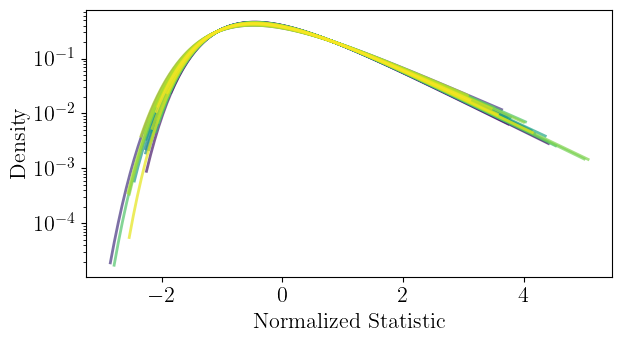

In [98]:
mean_noise = all_best_losses_noise.mean(axis=0)
std_noise = all_best_losses_noise.std(axis=0)
normalized = (all_best_losses_noise - mean_noise) / std_noise

plt.figure()
# Get colormap and normalize for number of templates
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, normalized.shape[1]-1)

# Plot histograms and fitted Gumbel distributions for each template
for ii in range(normalized.shape[1]):
    color = cmap(norm(ii))
    params = gumbel_r.fit(normalized[:,ii])
    x_range = np.linspace(normalized[:,ii].min(), normalized[:,ii].max(), 100)
    plt.plot(x_range, gumbel_r.pdf(x_range, *params), '-', linewidth=2, color=color, alpha=0.7)
plt.semilogy()
plt.xlabel('Normalized Statistic')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('gumbel_fits.pdf')

# Try to load cached results if available, otherwise process and save

In [99]:
cache_file = "results_detection_cache_tdi.pkl"
if os.path.exists(cache_file):
    print(f"Loading cached results from {cache_file}")
    with open(cache_file, "rb") as f:
        results_detection, snr_values = pickle.load(f)
else:
    # Process signal-injected realizations
    results_detection = []
    snr_values = []
    dirs = glob.glob("../tdi_search/*")
    
    if not dirs:
        print("Error: No signal-injected realization directories found.")
        exit(1)

    for output_dir in dirs:
        h5_file = os.path.join(output_dir, 'best_results.h5')
        if not os.path.exists(h5_file):
            print(f"Warning: {h5_file} not found. Skipping.")
            continue

        current_tpl, current_losses, param_dict, best_fs = load_best_results(h5_file)
        with h5py.File(h5_file, 'r') as f:
            snr = f['SNR'][()]
            rel_diff_medians = f['rel_diff_stats/medians'][()]  # Load medians from the group

        if not np.array_equal(tpl_vector, current_tpl):
            print(f"Warning: Tpl_vector mismatch in {output_dir}. Skipping.")
            continue

        f0 = best_fs[:,:5].mean(axis=-1)
        fdot0 = np.gradient(best_fs, 5e4, axis=-1)[:,:5].mean(axis=-1)
        param_dict["f0"] = f0
        param_dict["fdot0"] = fdot0
        param_dict["losses"] = -current_losses
        param_dict["snr"] = float(snr)
        param_dict["rel_diff_medians"] = rel_diff_medians  # Add rel_diff_medians to param_dict
        results_detection.append(param_dict)
        snr_values.append(float(snr))
        print(f"Processed {h5_file}: SNR={snr}")

    if not results_detection:
        print("Error: No valid signal-injected realizations processed.")
        exit(1)

    # Save to cache for future runs
    with open(cache_file, "wb") as f:
        pickle.dump((results_detection, snr_values), f)
    print(f"Saved processed results to {cache_file}")

# Convert to arrays
snr_values = np.array(snr_values)

Loading cached results from results_detection_cache_tdi.pkl


<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:80: SyntaxWarning: invalid escape sequence '\%'
<>:81: SyntaxWarning: invalid escape sequence '\%'
<>:82: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:80: SyntaxWarning: invalid escape sequence '\%'
<>:81: SyntaxWarning: invalid escape sequence '\%'
<>:82: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_16749/173616177.py:14: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_ylabel('Relative Frequency Error (\%)', color="gray")
/tmp/ipykernel_16749/173616177.py:80: SyntaxWarning: invalid escape sequence '\%'
  ax2.plot(unique_snrs, 100 * acc_err_h, ".:", color="gray", label="95\%", zorder=0)
/tmp/ipykernel_16749/173616177.py:81: SyntaxWarning: invalid escape sequence '\%'
  ax2.plot(unique_snrs, 100 * acc_err_l, ".:", color="gray", label="90\%", zorder=0)
/tmp/ipykernel_16749/173616177.py:82: SyntaxWarning: invalid escape sequence '\%'
  ax2.plot(unique_snrs, 100 * 

Quantile for detection: 2.4603503954659938
Detection probability for 20.0: 0.7070707070707071 ± 0.04573990171415522
Detection probability for 25.0: 0.898989898989899 ± 0.030286020461497483
Detection probability for 30.0: 0.9678714859437751 ± 0.007902044959356178
Detection probability for 35.0: 0.98989898989899 ± 0.01004986541743616
Detection probability for 40.0: 1.0 ± 0.0
25.186727618889222 -0.6216871815502145 -0.5675606954048362
28.154294981100634 -0.7414476064241171 -0.731663006964709
Detection threshold: 2.4603503954659938 Alpha: 0.01 acc_med [0.01737735 0.00307958 0.00245767 0.00199303 0.001223  ]


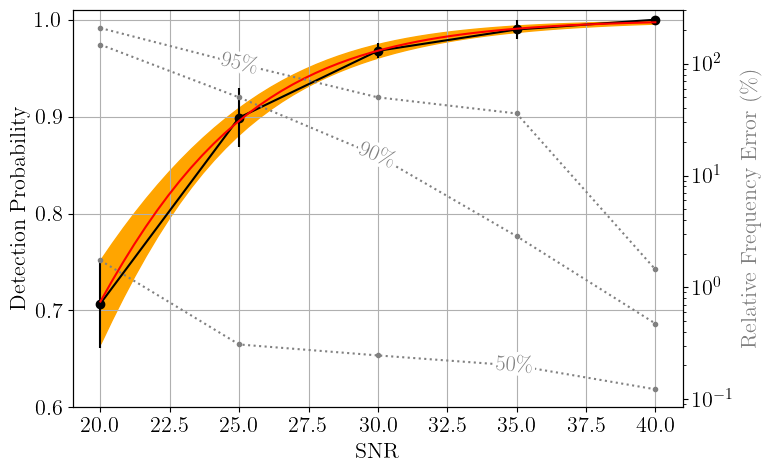

In [147]:
# Plot detection probability vs SNR for different significance levels
# Create a figure with two subplots sharing the x-axis
fig, ax = plt.subplots(figsize=(8, 5))

ax.set_ylabel('Detection Probability')
ax.grid(True)
ax.set_xlabel('SNR')

#ax1.legend()
ax.set_ylim(0.6, 1.01)


ax2 = ax.twinx()
ax2.set_ylabel('Relative Frequency Error (\%)', color="gray")
ax2.set_yscale('log')
# ax2.set_ylim(3e-4, 1e-2)


# Detection probability vs SNR for different significance levels
colors = ["black"]  # Colors for different alpha values
linestyles = ['-']  # Different line styles
markers = ['d']  # Different markers
ms = 6  # Marker size

detection_threshold = get_detection_threshold(normalized)

unique_snrs, detection_probs_snr, detection_std_probs_snr = compute_detection_probability(results_detection, snr_values, detection_threshold)

ax.errorbar(unique_snrs, detection_probs_snr, yerr=detection_std_probs_snr, fmt="o-", color="black")

# Do the fit
def sigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-(x - b) / a))
    
def sigmoid_envelope(x, a, b, cov):
    common_factor = sigmoid(x, a, b) * (1 - sigmoid(x, a, b))
    df_da = -(x-b)/(a**2) * common_factor
    df_db = -1/a * common_factor
    return np.sqrt(
        df_da**2 * cov[0][0] + df_db**2 * cov[1][1] + 2 * df_da * df_db * cov[1][0]
    )

param, covariance = curve_fit(
    sigmoid,
    xdata=unique_snrs[:4],
    ydata=detection_probs_snr[:4],
    sigma=detection_std_probs_snr[:4],
    absolute_sigma=True,
    bounds=[[0, 0], [50, 50]],
)

for detection_probability in [0.9, 0.95]:
    star = bisect(lambda x: detection_probability - sigmoid(x, *param), 20, 50)
    
    
    star_err_right = -star + bisect(
        lambda x: sigmoid(x, *param)
        +  sigmoid_envelope(x, *param, covariance)
        - detection_probability,
        20,
        50,
    )
    
    star_err_left = star - bisect(
        lambda x: sigmoid(x, *param)
        - sigmoid_envelope(x, *param, covariance)
        - detection_probability,
        20,
        50,
    )

    print(star, star_err_right, star_err_left)

x = np.linspace(20, 40)
ax.plot(x, s := sigmoid(x, *param), color="red", zorder=10)
ax.fill_between(x, s - sigmoid_envelope(x, *param, covariance), s + sigmoid_envelope(x, *param, covariance), color="orange") 


unique_snrs, acc_med, acc_err_l, acc_err_h = compute_accuracy(results_detection, snr_values, detection_threshold)
ax2.plot(unique_snrs, 100 * acc_err_h, ".:", color="gray", label="95\%", zorder=0)
ax2.plot(unique_snrs, 100 * acc_err_l, ".:", color="gray", label="90\%", zorder=0)
ax2.plot(unique_snrs, 100 * acc_med, ".:", color="gray", label="50\%", zorder=0)

labellines.labelLines(ax2.get_lines())
print("Detection threshold:", detection_threshold, "Alpha:", alpha, "acc_med", acc_med)

plt.tight_layout()
plt.savefig('detection_and_accuracy_vs_snr.pdf')
 

In [128]:
detection_std_probs_snr

array([0.0457399 , 0.03028602, 0.00790204, 0.01004987, 0.        ])

In [ ]:
####################################################
# Scatter plot Tpl vs ef, colored by SNR, markers by detection
expected_snrs = [25, 30, 35]

cmap = plt.get_cmap('inferno')
cmap = plt.get_cmap(salsa.pesto)

alpha = 0.001  # Use default alpha for scatter plot
detection_threshold = get_detection_threshold(normalized, alpha)
quantile_detection = np.quantile(normalized, 1-alpha/len(tpl_vector), axis=0)
norm_ds = np.array([np.max((r['losses'] - mean_noise)/std_noise) for r in results_detection])
detected = np.array([np.any(np.max((r['losses'] - mean_noise)/std_noise) > detection_threshold) for r in results_detection])

m1_values = np.array([r['m1'] for r in results_detection])
m2_values = np.array([r['m2'] for r in results_detection])
tpl_values = np.array([r['Tpl'] for r in results_detection])
ef_values = np.array([r['e0'] for r in results_detection])
dist_values = np.array([r['dist'] for r in results_detection])
f0_values = np.array([r['f0'][np.argmax(np.max((r['losses'] - mean_noise)/std_noise))] for r in results_detection])
fdot0_values = np.array([r['fdot0'][np.argmax(np.max((r['losses'] - mean_noise)/std_noise))] for r in results_detection])

M_chirp_values = chirpmass_from_f_fdot_few(f0_values, fdot0_values)
M_chirp_noise = chirpmass_from_f_fdot_few(noise_f, noise_fdot)

norm = plt.Normalize(1.0, 100.0)


fig, ax = plt.subplots()
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=r'$m_2$ [$M_\odot$]')
for snr, mark in zip(expected_snrs, [pasta.penne, pasta.rigatoni, pasta.farfalle]):
    mask = np.isclose(snr_values, snr, rtol=1e-3)
    det_mask = mask & detected
    if np.any(det_mask):
        z_values = np.array([z_at_value(Planck18.luminosity_distance, d*u.Gpc) for d in dist_values[det_mask]])
        color_list = [cmap(norm(el)) for el in m2_values[det_mask]/(1+z_values)]
        plt.scatter(m1_values[det_mask]/(1+z_values), z_values, marker=mark, c=color_list, alpha=0.7)
        plt.semilogx()
        # plt.scatter(m1_values[det_mask]/(1+z_values), dist_values[det_mask], marker=mark, c=color_list, alpha=0.7)


detected_marker = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=7, label='Detected')
not_detected_marker = mlines.Line2D([], [], color='k', marker='x', linestyle='None', markersize=7, label='Not detected')

# Create color patches for SNR legend
snr_legend = [mlines.Line2D([], [], color='k', marker=mark, linestyle='None', markersize=7, label=f'SNR={snr}') for snr, mark in zip(expected_snrs, [pasta.penne, pasta.rigatoni, pasta.farfalle])]
# Combine legends
plt.legend(handles=snr_legend, loc='best')

plt.xlabel(r'$m_1$ [$M_\odot$]')
plt.ylabel(r'Redshift $z$')
plt.tight_layout()
plt.savefig('scatter.pdf')

In [ ]:
###############################################
# Build labels and scores for ROC

labels = []
scores = []
argmax_scores = []
print("Building labels and scores for ROC curve...")#, snr_values)
dict_labels = {snr: [] for snr in snr_values}

# Noise-only trials
for noise_row in all_best_losses_noise:
    det_stat = (noise_row - mean_noise) / std_noise
    score = np.max(det_stat)  # use the max statistic across time
    argmax_scores.append(np.argmax(det_stat))
    labels.append(0)
    scores.append(score)

# show argmax histogram
plt.figure()
plt.hist(argmax_scores, bins=len(tpl_vector), density=True, alpha=0.7)
plt.xlabel('Template Index of Max Score (Noise)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.savefig('argmax_histogram_noise.pdf')


# Signal+noise trials
for r in results_detection:
    det_stat = (r['losses'] - mean_noise) / std_noise
    score = np.max(det_stat)
    # define label as the SNR value
    labels.append(r['snr'])
    scores.append(score)

labels = np.array(labels)
scores = np.array(scores)

In [ ]:
# histogram of scores
plt.figure()
plt.hist(np.array(scores)[np.array(labels)==0], bins='auto', label='Noise', alpha=0.7, density=True)
linestyles = ['-', '--', '-.']
for i, snr in enumerate([25, 30, 35]):
    plt.hist(np.array(scores)[np.array(labels)==snr], bins=25, label=f'SNR$=${snr}', alpha=1.0, density=True, histtype='step', linewidth=2.5, linestyle=linestyles[i])
plt.semilogy()
# plt.ylim(1e-2, None)
plt.xlabel('Normalized Statistic ')
plt.ylabel('Density')
# plt.title('Histogram of Detection Statistic Scores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('score_histogram.pdf')

# Plot ROC
# Full ROC with inset
fig, ax = plt.subplots()

# Inset axes for zoomed region
axins = inset_axes(ax, width="50%", height="50%", loc='lower left',
                bbox_to_anchor=(0.45,0.08,0.5,0.5), bbox_transform=ax.transAxes)

mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

ax.plot([0,1],[0,1], lw=1, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
# ax.set_title('ROC curve for GW search pipeline')
ax.legend(loc='lower right')
plt.tight_layout()
ax.grid(True)

plt.savefig('roc_curve.pdf')

usage: ipykernel_launcher.py [-h]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/rodrigo/.local/share/jupyter/runtime/kernel-33818897-c1f9-4831-9d4f-96f8fbd6b602.json


SystemExit: 2

/home/rodrigo/miniforge3/envs/emris-sfts/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
